In [14]:
%matplotlib inline
from pylab import *
import khmer, screed

# Manipulating k-mer abundance spectra

Let's turn to the question of k-mer abundances.

Suppose you have 500x coverage of a 1kb single-copy linear DNA
sequence in 100 bp reads.  On average, with truly random and uniform
sampling, you would see every base in the true sequence 500 times,
with about half more frequently and half less frequently.
You could measure this quite easily with mapping - simply map
all the reads to the linear sequence, and then count the
number of times each base is covered by a read.

In [2]:
# @CTB

If, however, you don't know the true sequence, you can still estimate
the coverage by looking at the histogram of k-mer abundances, or
k-mer abundance spectrum:

In [3]:
!type abundance-dist.py

abundance-dist.py is /Users/t/dev/khmer/scripts/abundance-dist.py


In [5]:
!abundance-dist-single.py -q -k 21 -M 1e6 -s data/reads.fa.gz temp/hist.out

making countgraph
building k-mer tracking graph
kmer_size: 21
k-mer countgraph sizes: [227271, 227269, 227267, 227265]
outputting to temp/hist.out
consuming input, round 1 -- data/reads.fa.gz
Total number of unique k-mers: 16087
preparing hist from data/reads.fa.gz...
consuming input, round 2 -- data/reads.fa.gz
wrote to: temp/hist.out


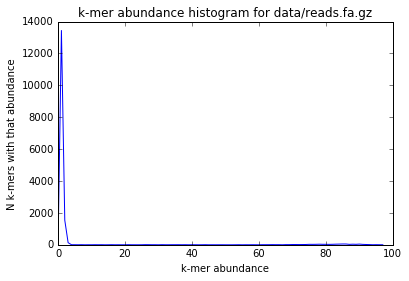

In [27]:
import numpy
hist = numpy.loadtxt('temp/hist.out', skiprows=1, delimiter=',')
plot(hist[:,0], hist[:,1])
title('k-mer abundance histogram for data/reads.fa.gz')
xlabel('k-mer abundance')
ylabel('N k-mers with that abundance')

Here, there are two peaks: one is the peak of true k-mer abundances,
which is around 400.  The other is the set of erroneous k-mers
resulting from sequencing errors.  The intuition is simple: in
general, erroneous k-mers will only show up a few times, while k-mers
that are generated from sampling true sequence will show up many
times.

(0.0, 10, 0.0, 14000.0)

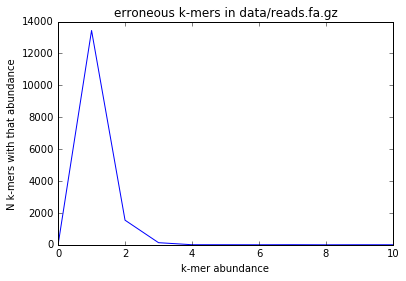

In [28]:
plot(hist[:,0], hist[:,1])
title('erroneous k-mers in data/reads.fa.gz')
xlabel('k-mer abundance')
ylabel('N k-mers with that abundance')
axis(xmax=10)

(0.0, 100.0, 0.0, 200)

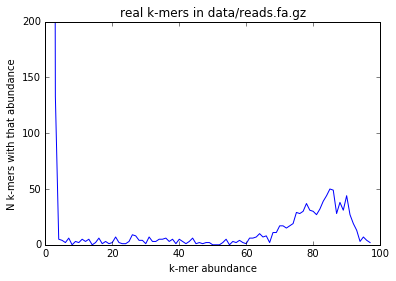

In [29]:
plot(hist[:,0], hist[:,1])
title('real k-mers in data/reads.fa.gz')
xlabel('k-mer abundance')
ylabel('N k-mers with that abundance')
axis(ymax=200)

If we color the true k-mers blue and the erroneous k-mers red, this is
quite clear:

Saving k-mer countgraph to temp/reads.kh
Loading kmers from sequences in ['data/reads.fa.gz']
making countgraph
consuming input data/reads.fa.gz
Total number of unique k-mers: 16087
saving temp/reads.kh
fp rate estimated to be 0.000
DONE.
wrote to: temp/reads.kh.info
Counting graph from temp/reads.kh
K: 21
outputting to temp/hist-real.csv
** squashing existing file temp/hist-real.csv
preparing hist...


(0.0, 100.0, 0.0, 200)

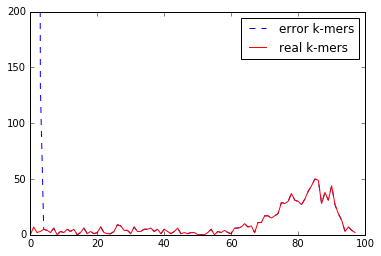

In [30]:
!load-into-counting.py -q -k 21 -M 1e6 temp/reads.kh data/reads.fa.gz
!abundance-dist.py -q -s temp/reads.kh data/genome.fa.gz temp/hist-real.csv
hist_real = numpy.loadtxt('temp/hist-real.csv', delimiter=',', skiprows=1)
plot(hist[:,0], hist[:,1], 'b--', label='error k-mers')
plot(hist_real[:,0], hist_real[:,1], 'r-', label='real k-mers')
legend(loc='upper right')
axis(ymax=200)

This is a nice demonstration of the "error catastrophe" of k-mer based views of sequencing data -- in any reasonable sequencing data set, there are many more erroneous k-mers (area under the left curve) than there are real k-mers (area under the right curve).

This difference in abundance peaks lets us do error analysis and trimming.

For example, errors can readily be identified in reads by looking at the first
location where a low-abundance k-mer appears:

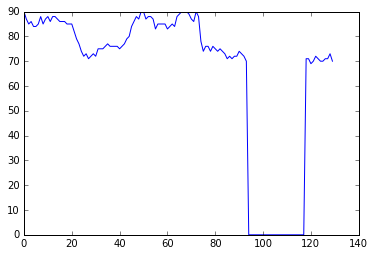

In [31]:
>>> cg = khmer.load_countgraph('temp/reads.kh')
>>> first_read = next(iter(screed.open('data/reads.fa.gz')))
>>> first_seq = first_read.sequence
>>> counts = cg.get_kmer_counts(first_seq)
>>> plot(range(len(counts)), cg.get_kmer_counts(first_seq))

And, of course, you can simply remove all the low-abundance k-mers from
reads altogether, leaving only the high-abundance k-mers:

loading countgraph: temp/reads.kh
K: 21
filtering data/reads.fa.gz
starting threads
starting writer
loading...
... filtering 0
done loading in sequences
DONE writing.
processed 666 / wrote 528 / removed 138
processed 99900 bp / wrote 47895 bp / removed 52005 bp
discarded 52.1%
output in temp/reads.trimmed.fa
making countgraph
building k-mer tracking graph
kmer_size: 21
k-mer countgraph sizes: [227271, 227269, 227267, 227265]
outputting to temp/trimmed.csv
consuming input, round 1 -- temp/reads.trimmed.fa
Total number of unique k-mers: 963
preparing hist from temp/reads.trimmed.fa...
consuming input, round 2 -- temp/reads.trimmed.fa
wrote to: temp/trimmed.csv


(0.0, 100.0, 0.0, 200)

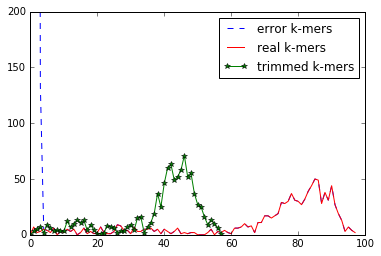

In [34]:
!filter-abund.py -q temp/reads.kh data/reads.fa.gz -C 5 -o temp/reads.trimmed.fa
!abundance-dist-single.py -q -s -k 21 -M 1e6 temp/reads.trimmed.fa temp/trimmed.csv
hist_trim = numpy.loadtxt('temp/trimmed.csv', delimiter=',', skiprows=1)
plot(hist[:,0], hist[:,1], 'b--', label='error k-mers')
plot(hist_real[:,0], hist_real[:,1], 'r-', label='real k-mers')
plot(hist_trim[:,0], hist_trim[:,1], 'g*-', label='trimmed k-mers')
legend(loc='upper right')
axis(ymax=200)

If you look at the k-mer abundance spectrum of the trimmed k-mers (green) against the
abundance spectrum of the whole data set (red), you will see that in effect we've
shifted the abundance spectrum left - this is because we are trimming reads
at low-abundance k-mers and discarding the remainder of the reads,
rather than simply ignoring the low abundance k-mers.

### Error trimming decreases memory consumption

Error trimming has the advantage of dramatically simplifying several issues: first,
you don't have nearly as many k-mers to keep track of, which can decrease
the total amount of memory needed to process the reads in another ways; and
second, assembly itself becomes much simpler if you are dealing with
only correct k-mers, because then only repeats are problematic.

On the flip side, as you can see above, you lose quite a bit of data - the abundance
histogram shifts quite far left - 

@@identify and mask low-abundance k-mers

What else can we do with k-mer abundance spectra?

## Variable coverage error trimming

The above approach of identifying low-abundance k-mers as errors works
well in situations where you have high, uniform coverage of the
molecules in your sample. This is possible to achieve with genomes by
doing deep enough sequencing because the single copy sequence will be
represented uniformly.  But what about transcriptomes and metagenomes
and MD-amplified samples?  Any such samples of sufficient diversity
will have both high-abundance components and low-abundance components.

For example, consider a two-species metagenome, where one species
(species A) is present at 100x the abundance of the other.  If we
sequence species A to 500x, species B will still only be present
at 5x within the sample:

In [ ]:
>>> 

If we abundance trim at k-mers with abundance 3 as above, we'll eliminate
almost all of the real data from species B, along with many of the errors
in species A.

In [ ]:
>>> 

There's an additional problem, too: deep sequencing of highly abundant
molecules will yield erroneous k-mers with abundance > 3.

What we need to do here is apply a cutoff that takes into account the
local abundance of the read.  While this may not be something that we
know, we can estimate it on a per-read basis by looking at the other
k-mers in the read -- for example, if most of the k-mers in a read are
high abundance in the overall data set, then probably the read itself
is high abundance and any low-abundance k-mers in it are erroneous.

Practically speaking, we can guess the abundance of a read by using
the median k-mer abundance of the k-mers in a read with respect to the
overall k-mer spectrum.  We can then choose our trimming cutoff so
that k-mers outside the natural sampling spread of k-mers within the
read are identified as errors:

In [ ]:
# @@use ratio?
# %%

This has the effect of trimming off many errors for the high abundance
reads, and trimming effectively no low-abundance reads.  This is OK:
it's very hard to recover data you've eliminated, and for
low-abundance reads, we must simply remain unsure of the distinction
between "true" and erroneous k-mers.

Underlying all of this, what we are really trying to do is estimate
whether or not a k-mer belongs to one of two Poisson distributions:
the "true k-mer" Poisson distribution, or the "erroneous k-mer" Poisson
distribution.  For each true k-mer, an erroneous k-mer occurs at
1/(k*3)th... so you're essentially sampling from...

## Estimating per-read coverage, more generally

The ability to estimate a read's coverage by looking at k-mer
abundances is pretty handy, because you can do it reference free and
therefore you can use it to extract *reads* from data sets without
assembling

(You can't use k-mer spectra alone to extract reads, because a read
may have a mixture of high and low abundance k-mers in it.)

For example, in the situation above with two species, it is easy to
extract all of the reads that belong to the high abundance species,
species A -- simply take any read with an estimated abundance greater
than 50.

%%

There may be other things you can do here too.

## Normalizing read coverages

Let's consider the situation above with two species A and B.  A is
kind of a problem -- the bulk of the sequencing data is from A, and
we don't really need 500x coverage to recover the true genome of A.

We could slice the reads out by coverage, and then subsample the
reads down to a coverage of 50 or 100 --

%%

@@hmmmm....

but it turns out we can do something that's effectively the same but
much more efficient: we can collect only the low-coverage reads, and
discard any high-coverage reads altogether.

%%

This is known as "digital normalization" of sequencing data, and it's
an efficient and effective way to eliminate redundant sequencing data.

(When do we discuss online processing and graphs?)

It also has the effect of reducing the error content of data all on its
own -- because we are discarding reads, we are also discarding errors
in those reads.

## Is the true sequence still present?

With all of these manipulations to remove errors and redundancy in
sequencing data sets, it is always nice to check that our beginning
principle holds true - that the k-mers of the true genomic sequence
remain in the data set.

A simple way to do that (in simulated data) is to use the abundance
histogram functionality to look to see how many true k-mers are
present in the read data set.

%%

Next: [Exploring graphs](exploring-graphs.html)